In [1]:
from gen.sample_generator import data_generator, stock_data_generator, stacked_data_generator
import numpy as np
from prediction.auxPlot import stacked_line_plots, stacked_lines_plots_w_anomalies
from prediction.auxFunction import get_mean_std_from_array, create_windows_feature_target, normalize_mean_std, train_test_split

# df = stacked_data_generator(start_date=(2023,1,1),
#                     end_date=(2023,2,2),
#                     perc_anomalies=0.08,
#                     regenerate=False
#                     )

df = stock_data_generator(start_date=(2023,1,1),
                    end_date=(2023,2,2),
                    perc_anomalies=0.08,
                    regenerate=False
                    )

Loading from filesystem c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9217 entries, 2023-01-01 00:00:00 to 2023-02-02 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stock_1  9217 non-null   float64
 1   stock_2  9217 non-null   float64
dtypes: float64(2)
memory usage: 216.0 KB


In [3]:
df.head()

,stock_1,stock_2
datetime,,
2023-01-01 00:00:00,2.377889,0.032361
2023-01-01 00:05:00,2.227047,-0.807202
2023-01-01 00:10:00,2.022227,-1.426083
2023-01-01 00:15:00,1.799659,-1.836901
2023-01-01 00:20:00,1.595574,-2.052274


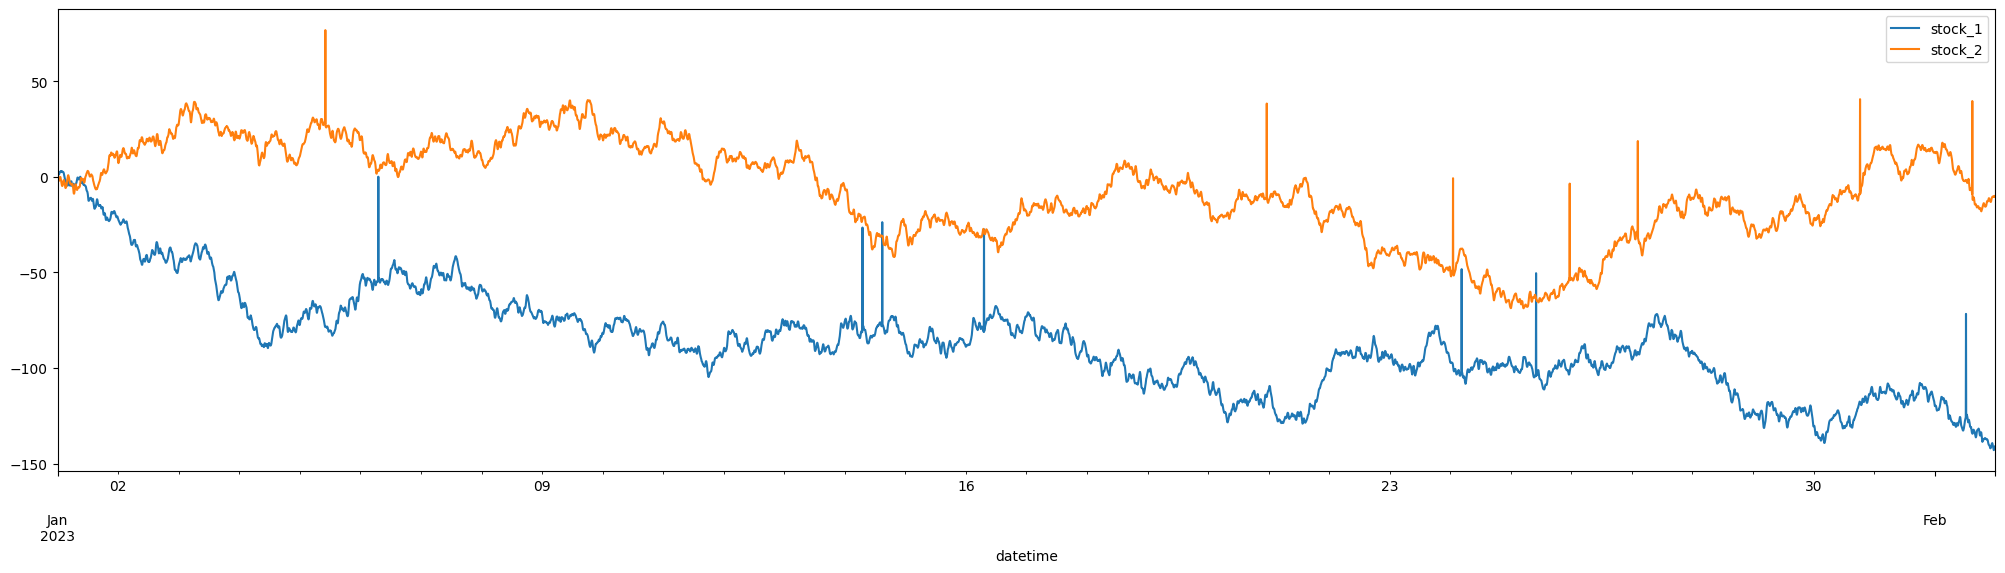

In [4]:
if 'dimension' in df.columns.to_list():
    stacked_line_plots(df[df.dimension=='C'], x='datetime', metrics=df.columns.to_list(), title="Plot")
else:
    df.plot(figsize=(25,6))

In [5]:
selected_columns = df.columns.to_list()
if 'dimension' in selected_columns:
    selected_columns.remove('dimension')

In [6]:
  
# Calculate overall mean and std
overall_mean, overall_std = get_mean_std_from_array(df[selected_columns])

In [7]:
# List to store windowed and normalized data for all cell_ids
X_list, y_list = [], []

window_size = 24

if 'dimension' in df.columns.to_list():
    for dim, group in df.groupby('dimension'):
        
        group = group.sort_index()

        # Normalize the data using the overall mean and std
        metrics_data_normalized = normalize_mean_std(group[selected_columns], mean=overall_mean, std=overall_std)

        # Create windowed sequences
        X_window, y_window = create_windows_feature_target(metrics_data_normalized, window_size, stride=2)

        # Append to the list
        X_list.append(X_window)
        y_list.append(y_window)
else:

    metrics_data_normalized = normalize_mean_std(df[selected_columns], mean=overall_mean, std=overall_std)

    # Create windowed sequences
    X_window, y_window = create_windows_feature_target(metrics_data_normalized, window_size, stride=2)

    # Append to the list
    X_list.append(X_window)
    y_list.append(y_window)

In [8]:
X_list = np.concatenate(X_list)
y_list = np.concatenate(y_list)
print(X_list.shape)
print(y_list.shape)

(4597, 24, 2)
(4597, 2)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
# Split the data into training and validation sets.
split_ratio = 0.8
X_train, y_train, X_val, y_val = train_test_split(X_list, y_list, split_ratio=split_ratio)
print(X_train.shape)
print(y_train.shape)

(3677, 24, 2)
(3677, 2)


In [11]:
# Step 2: Define a PyTorch Dataset and DataLoader
from torch.utils.data import DataLoader, random_split, TensorDataset
from prediction.nn_models import TimeSeriesDataset

batch_size = 4096

train_dataset = TimeSeriesDataset(X_train, y_train,'Train',window_size=window_size, output_size=len(selected_columns))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(X_val,y_val,'Validation', window_size=window_size, output_size=len(selected_columns))
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [12]:
# Reduced model hyperparameters
n_features = len(selected_columns)
num_layers = 3  # reduced from 3

learning_rate = 0.005
#batch_size = 32  # reduced from 64
other_params = {
    'window_size': window_size,
    'n_features': n_features,
    'layers': num_layers,
    'lr': learning_rate,
    'data_mean': overall_mean.tolist(),
    'data_std': overall_std.tolist()
    
}

from prediction.nn_models import LSTM_TimeSeriesModel_2
# Initialize the reduced Model, Loss, and Optimizer
# Now we can create a model and send it at once to the device
model = LSTM_TimeSeriesModel_2(n_features, num_layers, n_features)


loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# print(model.state_dict())

In [13]:
from prediction.genericReg import *

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('Anomaly')
sbs.add_graph()
sbs.train(n_epochs=1000, print_every=100)
sbs.save_checkpoint('model/model_checkpoint.pth', **other_params)

# print(model.state_dict())

Setting device: cuda
Epoch [100/1000]	Training-Loss: 0.3125	Validation-Loss: 0.6422
Epoch [200/1000]	Training-Loss: 0.0816	Validation-Loss: 0.1628
Epoch [300/1000]	Training-Loss: 0.0219	Validation-Loss: 0.0569
Epoch [400/1000]	Training-Loss: 0.0108	Validation-Loss: 0.0316
Epoch [500/1000]	Training-Loss: 0.0079	Validation-Loss: 0.0220
Epoch [600/1000]	Training-Loss: 0.0067	Validation-Loss: 0.0171
Epoch [700/1000]	Training-Loss: 0.0060	Validation-Loss: 0.0141
Epoch [800/1000]	Training-Loss: 0.0056	Validation-Loss: 0.0122
Epoch [900/1000]	Training-Loss: 0.0053	Validation-Loss: 0.0108
Epoch [1000/1000]	Training-Loss: 0.0051	Validation-Loss: 0.0097


In [14]:
# %tensorboard --port 7000 --logdir runs

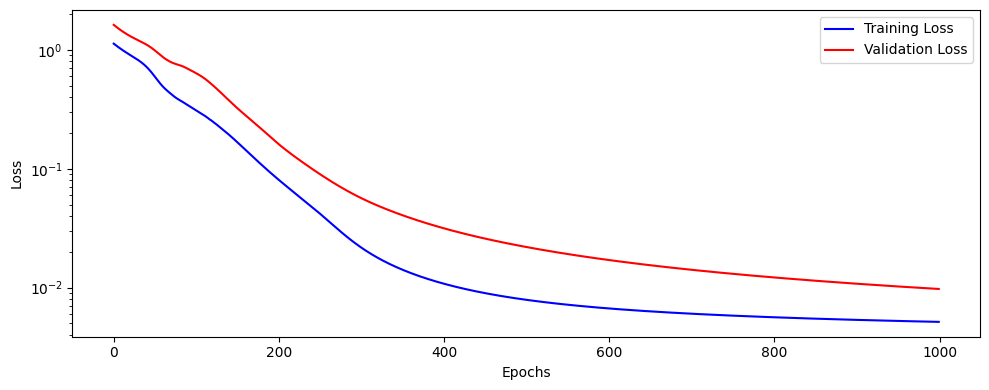

In [15]:
sbs.plot_losses()

In [16]:
sbs.generate_reconstruction_errors(bins=30)
print(sbs.reconstruction_loss_table)

                             bin_range  frequency
(-0.00198, 0.0659]  (-0.00198, 0.0659]        898
(0.0659, 0.132]        (0.0659, 0.132]         18
(0.132, 0.198]          (0.132, 0.198]          0
(0.198, 0.263]          (0.198, 0.263]          1
(0.263, 0.329]          (0.263, 0.329]          0
(0.329, 0.395]          (0.329, 0.395]          2
(0.395, 0.461]          (0.395, 0.461]          0
(0.461, 0.527]          (0.461, 0.527]          0
(0.527, 0.593]          (0.527, 0.593]          0
(0.593, 0.658]          (0.593, 0.658]          0
(0.658, 0.724]          (0.658, 0.724]          0
(0.724, 0.79]            (0.724, 0.79]          0
(0.79, 0.856]            (0.79, 0.856]          0
(0.856, 0.922]          (0.856, 0.922]          0
(0.922, 0.988]          (0.922, 0.988]          0
(0.988, 1.054]          (0.988, 1.054]          0
(1.054, 1.119]          (1.054, 1.119]          0
(1.119, 1.185]          (1.119, 1.185]          0
(1.185, 1.251]          (1.185, 1.251]          0


Perform the prediction on the entire dataset now for one of the dimension if it is present

In [17]:
if 'dimension' in df.columns.to_list():
    
    df_ml = df.loc[df['dimension']=='B']
    df_ml = df_ml.sort_index()
else:
    df_ml = df

In [18]:
# Using `create_windows` function to create windowed sequences
new_X_window, new_y_window = create_windows_feature_target(df_ml[selected_columns], window_size)

# Step 4: Normalize the windowed data using original mean and std
new_X_window_normalized = (new_X_window - overall_mean) / overall_std
new_y_window_normalized = (new_y_window - overall_mean) / overall_std



# Create DataLoader if needed
new_dataset = TimeSeriesDataset(new_X_window_normalized, new_y_window_normalized,'All data', window_size=window_size, output_size=len(selected_columns))
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)



In [19]:
sbs.val_loader = new_loader
sbs.construct_anomalies(percentile=99.5)

In [20]:
#Here we calculate the number of anomalies 
print(f"Number of anomalies: {sbs.anomalies.sum()}")

Number of anomalies: 32


## Visualize the Anomalies detected on the original data

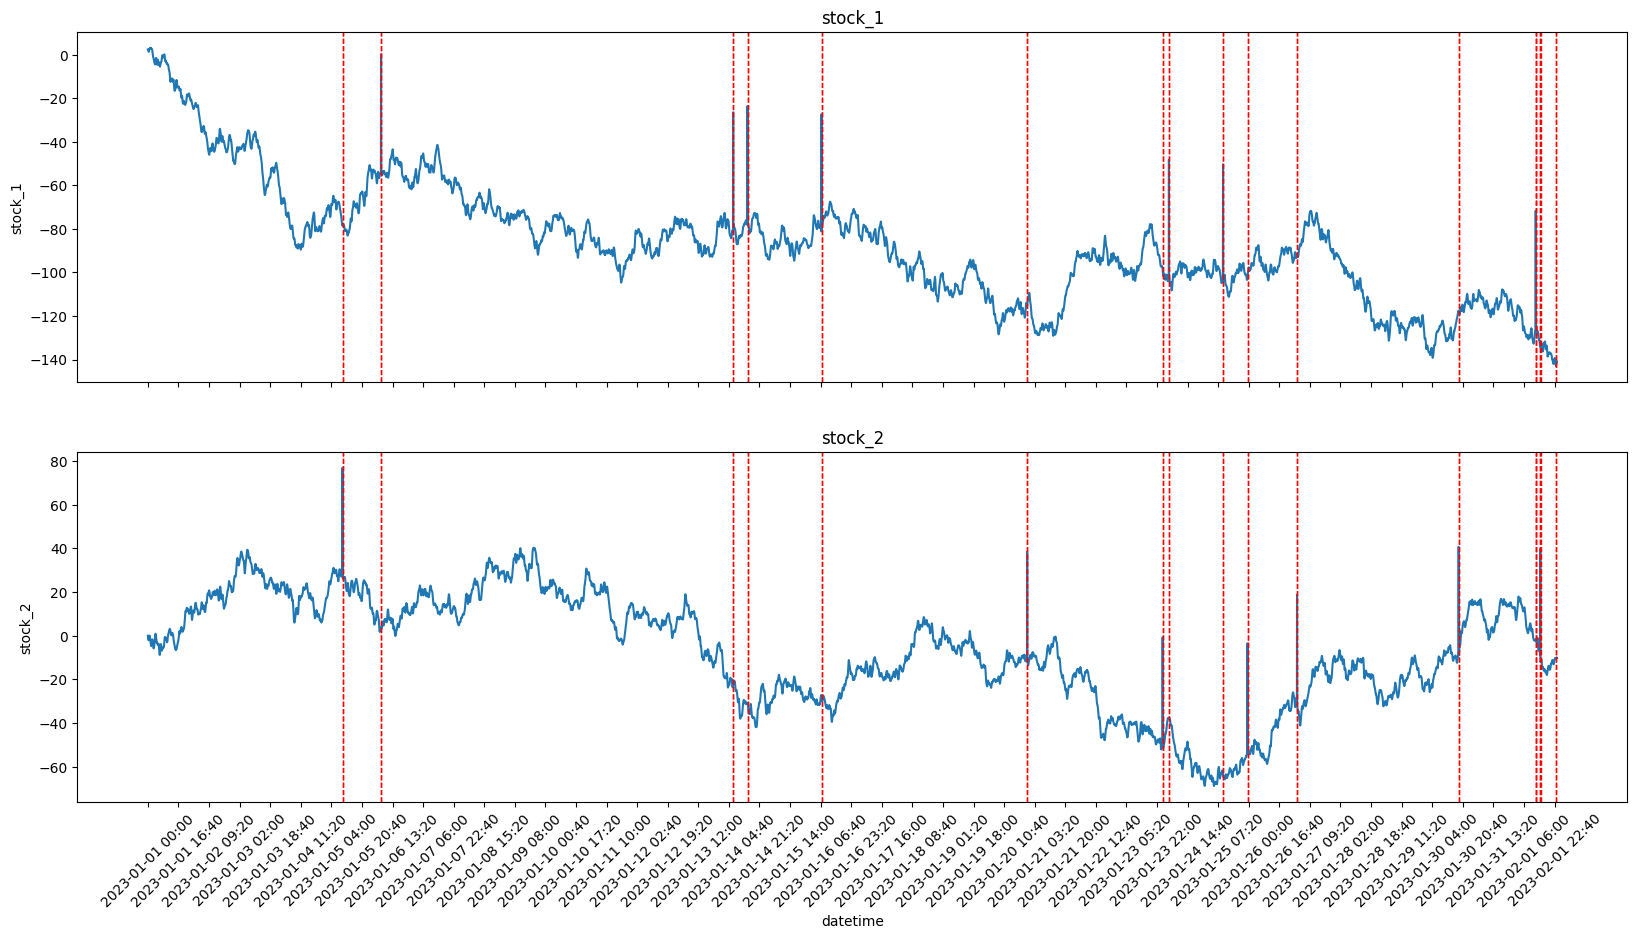

In [21]:

import matplotlib.pyplot as plt

# Prepare anomaly indices (same as previous examples)
anomalous_indexes_val = np.where(sbs.anomalies)[0]
original_anomalous_indexes = anomalous_indexes_val + window_size
anomaly_times = df_ml.index[original_anomalous_indexes]

stacked_lines_plots_w_anomalies(df_ml, metrics=selected_columns, anomaly_indices=anomaly_times)

## Export the model

In [22]:
sample_input = torch.randn(1, window_size, len(selected_columns))
torch.onnx.export(model,
                  sample_input.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')),
                  'model/model_onnx.onnx',
                  export_params=True,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'window_size'}, 
                                'output': {0: 'window_size'}}
                  )

c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [23]:
# Export metadata
import json

data = {
    'window_size': window_size,
    'selected_columns': selected_columns,
    'overall_mean': overall_mean.tolist(),
    'overall_std': overall_std.tolist()
    }
with open('model/model_data.json', 'w') as f:
    json.dump(data, f)